In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Select the dataset
dataset_name = "emnist/balanced"
# Load it into train_dataset and test_dataset with additional info in dataset_info
# the indicated split is 80% goes into training data and 20% for testing. The training dataset it further split into 90%:10% for train and validation
# as_supervised=True is used to also load the labels which is needed for classification
(train_dataset, valid_dataset, test_dataset), dataset_info = tfds.load(
    dataset_name,
    split=["train[:90%]", "train[90%:]", "test"],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteJQBWJ7/emnist-train.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteJQBWJ7/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.0.0. Subsequent calls will reuse this data.


In [2]:
# Display data about the data
print(f"Dataset Name: {dataset_name}")
print(f"Number of Classes: {dataset_info.features['label'].num_classes}")
print(f"Class Names: {dataset_info.features['label'].names}")
print(f"Total Samples: {dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples}")
print(f"Number of Training Samples: {dataset_info.splits['train[:90%]'].num_examples}")
print(f"Number of Validation Samples: {dataset_info.splits['train[90%:]'].num_examples}")
print(f"Number of Test Samples: {dataset_info.splits['test'].num_examples}")

Dataset Name: emnist/balanced
Number of Classes: 47
Class Names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46']
Total Samples: 131600
Number of Training Samples: 101520
Number of Validation Samples: 11280
Number of Test Samples: 18800


In [3]:
# A function to split the label from the images into X_valid/train and y_valid/train
def dataset_to_numpy(dataset):
   X = []
   y = []
   for features_labels in dataset:
       X.append(features_labels[0]/255)
       y.append(features_labels[1])
   X = np.array(X)
   y = np.array(y)
   return X, y

In [4]:
# Split the datasets
train_dataset = tfds.as_numpy(train_dataset)
X_train, y_train = dataset_to_numpy(train_dataset)

valid_dataset = tfds.as_numpy(valid_dataset)
X_valid, y_valid = dataset_to_numpy(valid_dataset)

test_dataset = tfds.as_numpy(test_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Get the shapes
print("Shapes:")
print(f"Training: X: {X_train.shape} Y: {y_train.shape}")
print(f"Validation: X: {X_valid.shape} Y: {y_valid.shape}")
print(f"Test: X: {X_test.shape} Y: {y_test.shape}")


Shapes:
Training: X: (101520, 28, 28, 1) Y: (101520,)
Validation: X: (11280, 28, 28, 1) Y: (11280,)
Test: X: (18800, 28, 28, 1) Y: (18800,)


In [5]:
number_of_classes=47

model = keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(units=512,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

model.summary()


model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 512)               6

In [6]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target labels
y_train_encoded = to_categorical(y_train, num_classes=47)
y_valid_encoded = to_categorical(y_valid, num_classes=47)
y_test_encoded = to_categorical(y_test, num_classes=47)

In [7]:
history = model.fit(X_train, y_train_encoded, epochs=10, verbose=2, batch_size=128, validation_data=(X_valid,y_valid_encoded))

Epoch 1/10
794/794 - 13s - loss: 1.1390 - accuracy: 0.6715 - val_loss: 0.5477 - val_accuracy: 0.8172 - 13s/epoch - 16ms/step
Epoch 2/10
794/794 - 3s - loss: 0.4887 - accuracy: 0.8346 - val_loss: 0.4586 - val_accuracy: 0.8426 - 3s/epoch - 4ms/step
Epoch 3/10
794/794 - 3s - loss: 0.4083 - accuracy: 0.8584 - val_loss: 0.4264 - val_accuracy: 0.8559 - 3s/epoch - 4ms/step
Epoch 4/10
794/794 - 3s - loss: 0.3651 - accuracy: 0.8706 - val_loss: 0.3899 - val_accuracy: 0.8648 - 3s/epoch - 4ms/step
Epoch 5/10
794/794 - 3s - loss: 0.3358 - accuracy: 0.8779 - val_loss: 0.3874 - val_accuracy: 0.8617 - 3s/epoch - 4ms/step
Epoch 6/10
794/794 - 3s - loss: 0.3130 - accuracy: 0.8851 - val_loss: 0.3753 - val_accuracy: 0.8717 - 3s/epoch - 4ms/step
Epoch 7/10
794/794 - 3s - loss: 0.2931 - accuracy: 0.8909 - val_loss: 0.3748 - val_accuracy: 0.8644 - 3s/epoch - 4ms/step
Epoch 8/10
794/794 - 3s - loss: 0.2742 - accuracy: 0.8973 - val_loss: 0.3717 - val_accuracy: 0.8726 - 3s/epoch - 4ms/step
Epoch 9/10
794/794 - 

Text(0, 0.5, 'Accuray')

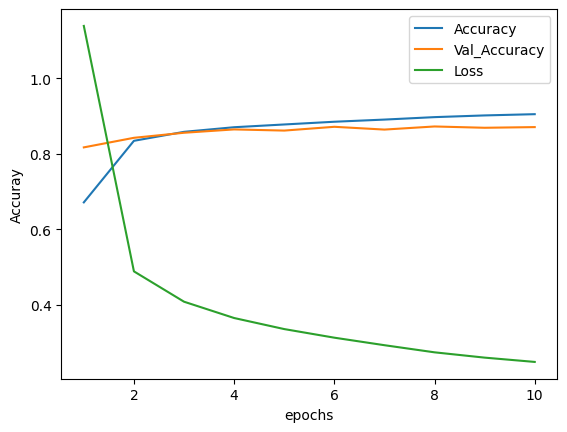

In [8]:
import seaborn as sns
q = len(history.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['loss'], label='Loss')
plt.xlabel('epochs')
plt.ylabel('Accuray')

In [9]:
model.evaluate(X_test, y_test_encoded)

588/588 [==============================] - 2s 3ms/step - loss: 0.3974 - accuracy: 0.8689


[0.39739251136779785, 0.868882954120636]